In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
import time
import pandas as pd
from datetime import date
from Ps_library_temp import *
from Hamiltonian_library import *
from config import *
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

In [69]:
system = Ps_system(N_atoms =1,N_bins = 200)
rabi0 = 2*np.pi*(500e-3)
chirp = 2*np.pi*(200e-3)
detuning = 0
direction = -1
pulse_duration = 3

laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
system.init_distribution_constant()
#system.init_MBdistribution()
system.init_states_excited()

laser = system.laserDict[0][1]
system.create_composite(laser)
args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
        "wavevector":laser.direction,
        "rabi":np.asarray(laser.rabi(laser.tlist,None)),
        "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
        "selector1":laser.selector1,
        "selector2":laser.selector2,
        "tlist":laser.tlist,
        "omega_L0":laser.omega_L0}
system.set_Hamiltonian_MT(args)

velocity_states = qt.Qobj(system.initial_pop)
_1S = qt.basis(system.internal_dims,0)
_2P = qt.basis(system.internal_dims,1)
comp_1S = qt.tensor(velocity_states,_1S)
comp_2P = qt.tensor(velocity_states,_2P)
print(comp_1S.unit().norm())

0.9999999999999998
1.0


In [84]:
H = []



H.append(hbar*omega0*system.tensor_e)
H.append([hbar*0.5*(system.tensor_ge2+system.tensor_eg2),laser.tlist-laser.tlist_centre])

(400, 400)
(400, 400)
Quantum object: dims = [[200, 2], [200, 2]], shape = (400, 400), type = oper, isherm = True
Qobj data =
[[262.26768351   0.           0.         ...   0.           0.
    0.        ]
 [  0.         262.26768351   0.         ...   0.           0.
    0.        ]
 [  0.           0.         262.26875694 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 262.48022134   0.
    0.        ]
 [  0.           0.           0.         ...   0.         262.48129476
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  262.48129476]]


In [82]:
rate = 1/3
spontaneous_emission_operator = qt.projection(system.internal_dims,0,1)
#print(spontaneous_emission_operator)
jump_operator = rate*qt.tensor(qt.qeye(system.N_bins),spontaneous_emission_operator)
#jump_operator = [rate*qt.tensor(system.kets_vel[n]*system.kets_vel[n].dag(),spontaneous_emission_operator) for n in range(system.N_bins)]
#print(jump_operator)


In [83]:
result = qt.mcsolve(H,tlist=laser.tlist,psi0 = comp_2P.unit(),e_ops = system.e_ops,c_ops=jump_operator,progress_bar=True,ntraj=500)
#result = qt.mcsolve(system.H,tlist=laser.tlist,psi0 = comp_2P,e_ops = system.e_ops,c_ops=[],progress_bar=True)

Exception: Error calculating H

P_g = 0.00307546320603385
P_e = 0.0019896297596073017


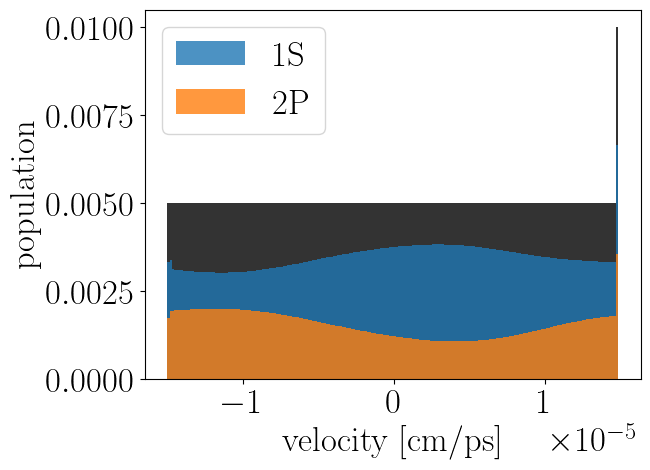

In [68]:
fig,ax = plt.subplots()
print("P_g = {}".format(result.expect[10][-1]))
print("P_e = {}".format(result.expect[210][-1]))
ax.hist(system.velocity_bins,system.velocity_bins, weights = np.asarray(result.expect)[200:400,0],alpha=0.8,color="black")
ax.hist(system.velocity_bins,system.velocity_bins, weights = np.asarray(result.expect)[0:200,-1],alpha=0.8,label="1S")
ax.hist(system.velocity_bins,system.velocity_bins, weights = np.asarray(result.expect)[200:400,-1],alpha=0.8,label="2P")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("population")
plt.legend()
#plt.savefig("figures/feb_2023/dissipation.jpg")
plt.show()

There is clearly an issue with the definition of the collapse operators. Let's try to define the Hamiltonian in the lab frame (for just 1 atom, because it's easier), and see if there's a difference

No c_ops, using sesolve
10.0%. Run time:   0.11s. Est. time left: 00:00:00:00
20.0%. Run time:   0.25s. Est. time left: 00:00:00:01
30.0%. Run time:   0.42s. Est. time left: 00:00:00:00
40.0%. Run time:   0.58s. Est. time left: 00:00:00:00
50.0%. Run time:   0.86s. Est. time left: 00:00:00:00
60.0%. Run time:   1.03s. Est. time left: 00:00:00:00
70.0%. Run time:   1.29s. Est. time left: 00:00:00:00
80.0%. Run time:   1.46s. Est. time left: 00:00:00:00
90.0%. Run time:   1.63s. Est. time left: 00:00:00:00
Total run time:   1.86s


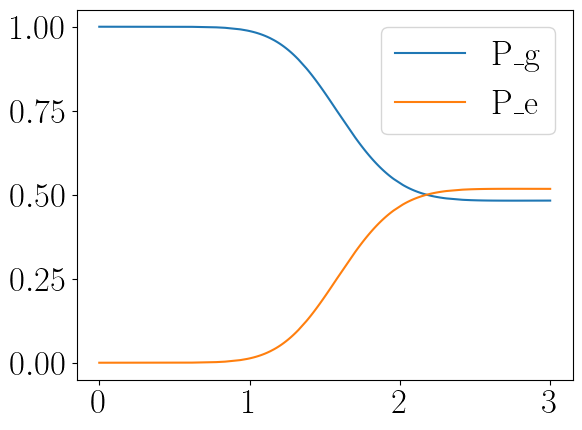

In [4]:
system = Ps_system(N_atoms =1,N_bins = 200)
rabi0 = 2*np.pi*(300e-3)
chirp = 2*np.pi*(100e-3)
detuning = 0
direction = 1
pulse_duration = 1

laser_guess = {"scale":0.1, "label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

v = 5e-6
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase = np.cos((1+v/c)*(laser.omega_L0-0.5*laser.chirp0*(laser.tlist-laser.tlist_centre))*(laser.tlist-laser.tlist_centre))

H = []
H.append(omega0*qt.Qobj([[0,0],[0,1]]))
H.append([qt.sigmax(),envelope*phase])

kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
rate = 1/pulse_duration
c_ops = []#np.sqrt(rate)*qt.projection(2,0,1)
result = qt.mcsolve(H,tlist=laser.tlist,psi0 = kets[0],e_ops = e_ops,c_ops=c_ops,progress_bar=True)
plt.plot(laser.tlist,result.expect[0],label=r"P_g")
plt.plot(laser.tlist,result.expect[1],label=r"P_e")
plt.legend()
plt.show()


No c_ops, using sesolve
10.8%. Run time:   0.00s. Est. time left: 00:00:00:00
21.6%. Run time:   0.00s. Est. time left: 00:00:00:00
32.4%. Run time:   0.00s. Est. time left: 00:00:00:00
40.5%. Run time:   0.00s. Est. time left: 00:00:00:00
51.4%. Run time:   0.01s. Est. time left: 00:00:00:00
62.2%. Run time:   0.01s. Est. time left: 00:00:00:00
70.3%. Run time:   0.01s. Est. time left: 00:00:00:00
81.1%. Run time:   0.01s. Est. time left: 00:00:00:00
91.9%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s


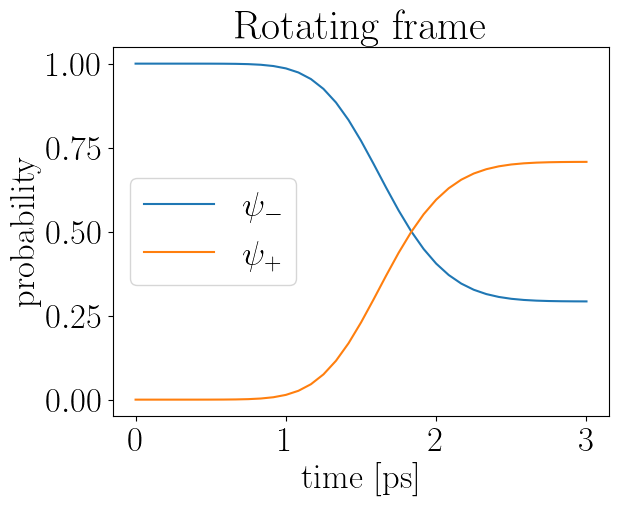

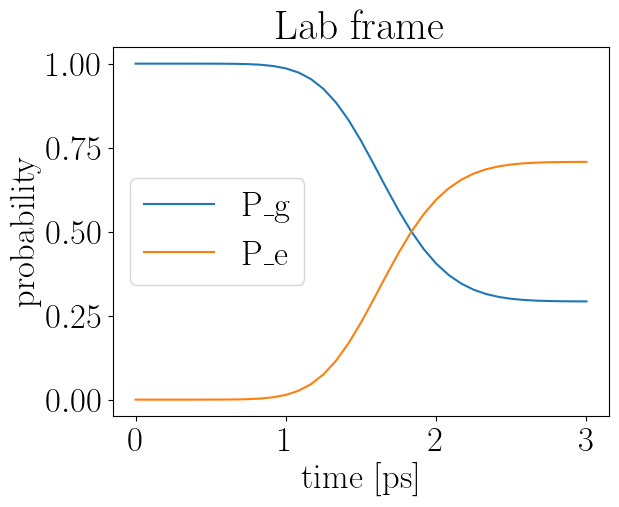

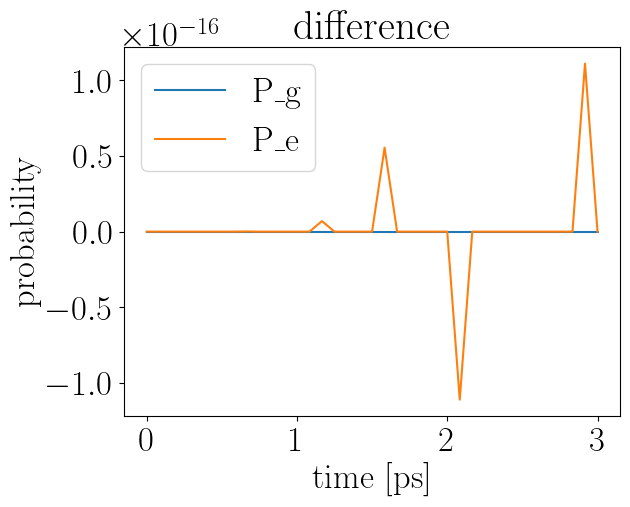

In [6]:
system = Ps_system(N_atoms =1,N_bins = 200)
laser_guess = {"label":"laser","order":0,"rabi0" : rabi0, "detuning": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration),"notch":0}
system.init_pulse(laser_guess)
system.init_pulse_cycle()
laser = system.laserDict[0][1]

v = 0
envelope = np.asarray([laser.rabi(t,None) for t in laser.tlist])
phase_time_independent = omega0 - (1+v/c)*laser.omega_L0
phase_time_dependent = (1+v/c)*laser.chirp0*(laser.tlist-laser.tlist_centre)

H = []
H.append(phase_time_independent*qt.Qobj([[0,0],[0,1]]))
H.append([qt.Qobj([[0,0],[0,1]]),phase_time_dependent])
H.append([0.5*qt.sigmax(),envelope])

kets = [qt.basis(2,i) for i in range(2)]
e_ops = [qt.ket2dm(ket) for ket in kets]
rate = 1/pulse_duration
c_ops = []#np.sqrt(rate)*qt.projection(2,0,1)
result = qt.mcsolve(H,tlist=laser.tlist,psi0 = kets[0],e_ops = e_ops,c_ops = c_ops,progress_bar=True)


phase = lambda t: omega0 - (1+v/c)*(laser.omega_L0-laser.chirp0*(t-laser.tcentre))
ket_rot = []
ket_lab = []
ket_lab_expect = []
for i in range(len(laser.tlist)):
    t = laser.tlist[i]
    ket_rot.append(qt.Qobj([[result.expect[0][i]],[result.expect[1][i]]]))
    U =  qt.Qobj([[1,0],[0,np.exp(1j*phase(t))]])
    
    ket_lab.append(U.dag()*ket_rot[i])
    P_g = np.abs(np.asarray(ket_lab[i][0])[0][0])
    P_e = np.abs(np.asarray(ket_lab[i][1])[0][0])
    
    
    #P_g = (ket_lab[i].dag()*e_ops[0]*ket_lab[i]).norm()
    #P_e = (ket_lab[i].dag()*e_ops[1]*ket_lab[i]).norm()
    ket_lab_expect.append([P_g,P_e])

plt.title("Rotating frame")
plt.plot(laser.tlist,result.expect[0],label=r"$\psi_-$")
plt.plot(laser.tlist,result.expect[1],label=r"$\psi_+$")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

plt.title("Lab frame")
plt.plot(laser.tlist,np.asarray(ket_lab_expect)[:,0],label=r"P_g")
plt.plot(laser.tlist,np.asarray(ket_lab_expect)[:,1],label=r"P_e")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

plt.title("difference")
plt.plot(laser.tlist,result.expect[0]-np.asarray(ket_lab_expect)[:,0],label=r"P_g")
plt.plot(laser.tlist,result.expect[1]-np.asarray(ket_lab_expect)[:,1],label=r"P_e")
plt.xlabel("time [ps]")
plt.ylabel("probability")
plt.legend()
plt.show()

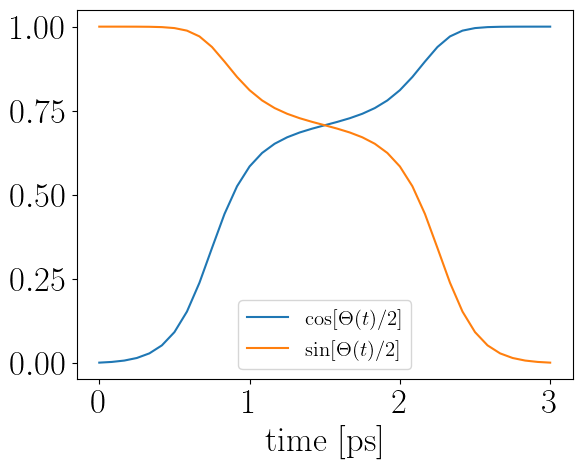

In [17]:
theta = lambda t: np.arccos(phase(t)/np.sqrt(phase(t)**2+np.abs(laser.rabi(t,None))**2))
plt.plot(laser.tlist,np.cos(theta(laser.tlist)/2),label=r"$\cos[\Theta(t)/2]$")
plt.plot(laser.tlist,np.sin(theta(laser.tlist)/2),label=r"$\sin[\Theta(t)/2]$")
plt.xlabel("time [ps]")
plt.legend(fontsize=15)
#plt.savefig("figures/feb_2023/cos_sin_melinger.jpg",bbox_inches="tight")
plt.show()
